In [140]:
import torch
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Preparing the Test data

In [141]:
from torch.utils.data import DataLoader, TensorDataset, random_split
import pandas as pd

# URL for MovieLens 100k dataset (you can change the URL for other versions)
url = '../data/ml-1m/ratings.dat'

# Load the dataset directly into a pandas DataFrame
df = pd.read_csv(url, sep='::', header=None, names=['user_id', 'item_id', 'rating', 'timestamp'], engine='python')
# Display the first few rows to confirm the dataset loaded correctly
print(df.head())

   user_id  item_id  rating  timestamp
0        1     1193       5  978300760
1        1      661       3  978302109
2        1      914       3  978301968
3        1     3408       4  978300275
4        1     2355       5  978824291


## Mapping the value

In [142]:
# Take the unique value and mapping it
user_mapping = {user_id: idx for idx, user_id in enumerate(df['user_id'].unique())} 
item_mapping = {item_id: idx for idx, item_id in enumerate(df['item_id'].unique())}

# Applying the mappings
df['user_id'] = df['user_id'].map(user_mapping)
df['item_id'] = df['item_id'].map(item_mapping)

print(df.head())

   user_id  item_id  rating  timestamp
0        0        0       5  978300760
1        0        1       3  978302109
2        0        2       3  978301968
3        0        3       4  978300275
4        0        4       5  978824291


## Tranform the data to the matrix 

In [143]:
from sklearn.preprocessing import MinMaxScaler
# Normalize ratings to a scale from 0 to 1 (for a better NN)
scaler = MinMaxScaler()
df['rating']= scaler.fit_transform(df[['rating']])

# Convert to a user-item matrix, the missing value will be -1 (we will compute the observe value)
user_item_matrix = df.pivot(index='user_id', columns='item_id', values='rating').fillna(-1)

# print(user_item_matrix)
# Convert to numpy array and then to torch tensors
user_item_matrix = user_item_matrix.values
user_item_matrix_tensor = torch.tensor(user_item_matrix, dtype=torch.float32)
# Create a mask where 1 indicates observed and 0 indicates missing values
mask = (user_item_matrix != -1).astype(float)
# print(mask)
mask = torch.tensor(mask, dtype=torch.float32)

## Split the data

In [144]:
from utils import transform2d_ml

# Create a dataset
dataset = TensorDataset(user_item_matrix_tensor, mask)

# Split the dataset into 70% training, 15% validation, and 15% test
train_size = int(0.7 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_data, val_data, test_data = random_split(dataset , [train_size, val_size, test_size])

# Create a dataLoader for training, validation, and testing
batch_size = 64
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

## Training

In [151]:
from autorec import AutoRec

model = AutoRec(user_item_matrix.shape[1], 500 , device)

model.to(device)

train_losses, val_losses = model.train_model(train_loader, val_loader,
                                         num_epochs=25,lr=0.002, reg=1e-5)

Epoch 1/25, Train Loss: 0.0966, Val Loss: 0.3483, Time: 0.72s
Epoch 2/25, Train Loss: 0.0755, Val Loss: 0.3651, Time: 0.73s
Epoch 3/25, Train Loss: 0.0766, Val Loss: 0.3655, Time: 0.74s
Epoch 4/25, Train Loss: 0.0763, Val Loss: 0.3760, Time: 0.74s
Epoch 5/25, Train Loss: 0.0766, Val Loss: 0.3866, Time: 0.77s
Epoch 6/25, Train Loss: 0.0771, Val Loss: 0.3859, Time: 0.75s
Epoch 7/25, Train Loss: 0.0769, Val Loss: 0.3823, Time: 0.78s
Epoch 8/25, Train Loss: 0.0777, Val Loss: 0.3721, Time: 0.76s
Epoch 9/25, Train Loss: 0.0773, Val Loss: 0.3748, Time: 0.76s
Epoch 10/25, Train Loss: 0.0774, Val Loss: 0.3701, Time: 0.76s
Epoch 11/25, Train Loss: 0.0650, Val Loss: 0.3421, Time: 0.75s
Epoch 12/25, Train Loss: 0.0614, Val Loss: 0.3408, Time: 0.76s
Epoch 13/25, Train Loss: 0.0613, Val Loss: 0.3400, Time: 0.75s
Epoch 14/25, Train Loss: 0.0613, Val Loss: 0.3393, Time: 0.77s
Epoch 15/25, Train Loss: 0.0612, Val Loss: 0.3385, Time: 0.77s
Epoch 16/25, Train Loss: 0.0611, Val Loss: 0.3374, Time: 0.78s
E

## Plot the Error function

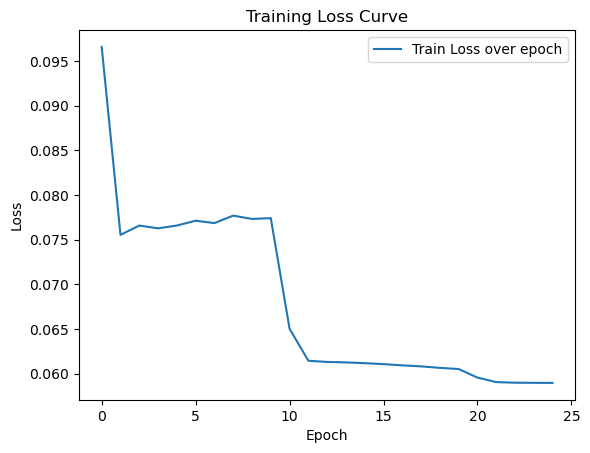

In [152]:
plt.plot( train_losses, label="Train Loss over epoch")
# plt.plot( val_losses, label = "Val Loss over epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss Curve")
plt.legend()
plt.show()

In [153]:
# print("Test Loss: ", model.evaluate(test_loader=test_loader))
print(4 * model.evaluate(test_loader))


0.966830385619724
